In [1]:
import torch
from torchvision import transforms as T
import torchvision as tv

import xformers
import numpy as np

# Load model

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.eval().cuda()

Using cache found in /home/thjo/.cache/torch/hub/facebookresearch_dinov2_main
/home/thjo/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/thjo/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/thjo/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
pretrained_depth_meta = torch.load("models/dinov2_vits14_nyu_dpt_head.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image tensor shape: torch.Size([1, 3, 336, 336]), min: 0.32954999804496765, max: 2.640000104904175


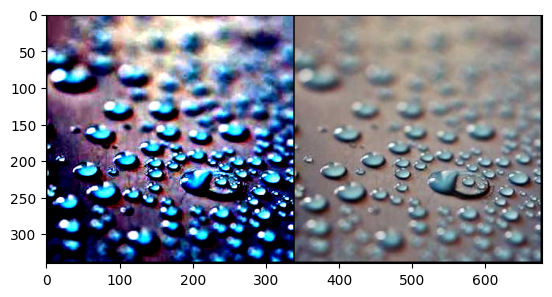

In [5]:

# Load an image from URL
import requests
from PIL import Image
from io import BytesIO
img_size = 14*24
url = f'https://picsum.photos/{img_size}'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
# Preprocess image

preprocess = T.Compose([
    lambda x: x.convert("RGB"),
    T.Resize(14*24),
    T.CenterCrop(14*24),
    T.ToTensor(),
    T.Lambda(lambda x: x.mul(255)),
    T.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])
img_tensor = preprocess(img).cuda()
img_tensor = img_tensor.unsqueeze(0) # add batch dimension
img0 = np.array(img)

print(f"Image tensor shape: {img_tensor.shape}, min: {img_tensor.mean()}, max: {img_tensor.max()}")
# Display image, and image tensor. Note that the image tensor is normalized, and the values are in [-1, 1].

import matplotlib.pyplot as plt
# Make grid
grid = tv.utils.make_grid(tensor=[img_tensor[0].cpu(),torch.from_numpy(img0).permute(2,0,1)/255], nrow=3,scale_each=True).numpy()
# Transpose to channels first
plt.imshow(grid.transpose(1,2,0))


In [ ]:
# Move to GPU

img_tensor = img_tensor.cuda()
dinov2_vits14 = dinov2_vits14.cuda()

In [ ]:

# Predict

with torch.no_grad():
    logits = dinov2_vits14(img_tensor)
    intermediate = dinov2_vits14.get_intermediate_layers(img_tensor)
    probs = logits.softmax(dim=-1)
    top5 = probs.topk(5)
    print(top5)

torch.return_types.topk(
values=tensor([[0.1330, 0.0654, 0.0623, 0.0494, 0.0453]], device='cuda:0'),
indices=tensor([[216, 279, 289, 193, 294]], device='cuda:0'))


In [ ]:
# Check how many parameters are in the model

print(f"Number of parameters: {sum(p.numel() for p in dinov2_vits14.parameters()):,}")

Number of parameters: 22,056,576


In [ ]:
from thop import profile

macs, params = profile(dinov2_vits14, inputs=(img_tensor, ))

print(f"Number of parameters: {params:,}")
print(f"Number of MACs: {macs:,}")




[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Number of parameters: 21,520,512.0
Number of MACs: 12,404,037,120.0


In [ ]:
dir(dinov2_vits14)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_intermediate_layers_chunked',
 '_get_intermediate_layers_not_chunked',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffer